# Jupyter Kernel for SoS

[Jupyter](http://jupyter.org/) notebook is a web application that allows you to create documents with live code and results. The underlying interpreters of the cells are called **kernel**. For example, you can use a `python` kernel to interpret python expressions, or a `ir` kernel to interpret `R` commands. You can use sos within a `python` kernel by loading the [`sos_magic` ipython extension](SoS_magic.html), or use a `sos` kernel to work in a complete SoS environment.

In addition to the ability to execute SoS workflows within Jupyter, the SoS kernel allows you to start subkernels (e.g. [`irkernel`](https://github.com/IRkernel/IRkernel) for [the R langauage](https://www.r-project.org/)) and switch between the subkernels in the same notebook. This allows for truly integrated data analysis using different langauages.

## Installing the SoS kernel

The SoS installation process will install a SoS kernel by default. To verify if you have the sos kernel installed, use command `jupyter kernelspec list` from command line (here we use the `!` magic to run commands from Jupyter notebook):

In [1]:
!jupyter kernelspec list

Available kernels:
  python3    /Users/bpeng1/anaconda/lib/python3.5/site-packages/ipykernel/resources
  bash       /Users/bpeng1/Library/Jupyter/kernels/bash
  ir         /Users/bpeng1/Library/Jupyter/kernels/ir
  sos        /Users/bpeng1/anaconda/share/jupyter/kernels/sos


and check if you have `sos` listed as one of the kernels. If not, try to re-install SoS using `pip3 install sos --upgrade` or clone SoS locally and run `python setup.py install`. If the kernel is installed, fire Jupyter using command
```
$ jupyter notebook
```
from the `New` button to the top right corner, select `SoS`, and create a SoS notebook.

You can also start a qtconsole with the SoS kernel using command
```
$ jupyter qtconsole --kernel sos
```
or even [use the SoS kernel in Spyder](Using_SoS_with_Spyder.html). Most of the features described in this section also applies to `qtconsole` and `spyder`.

Note that SoS uses [imagemagick](http://www.imagemagick.org/script/index.php) and python package [`wand`](http://docs.wand-py.org/en/0.4.2/) to preview output files so it is recommended that you install these packages.

## Acceptable statements in notebooks

You can enter any SoS expression, statements, and workflows in a Jupyter notebook. More specifically, you can enter

* any Python expression and statements. For example, you can write pieces of SoS code and evaluate them

In [2]:
res_path = '/path/to/resource'
ref_genome = "${res_path}/hg19"

* any SoS actions in function or script format. For example, you can execute a shell script using

In [3]:
run:
    echo Reference genome is located at ${ref_genome}

Reference genome is located at /path/to/resource/hg19


* markdown cells to document your workflow. These cells are not evaluated by SoS so string interpolations are not available to these cells.

* SoS workflows with one or more steps.

In [4]:
[10]
print("I am in ${step_name}")
[20]
print("I am in ${step_name}")
[30]
print("I am in ${step_name}")

I am in default_10
I am in default_20
I am in default_30


Technically speaking, SoS prefixes input with a default header if no header is present, and execute all input as SoS workflows. The major differences between running SoS scripts in batch mode and Jupyter notebook is the scope of variables. Whereas in Jupyter notebook all scripts are executed in the same namespace (SoS dictionary) with shared variables, SoS batch mode executes each step in separate processes with their own namespaces, with additional rules such as readonly global variables.

## Use of subkernels

One of the most important features of the SoS kernel is its support for multiple Jupyter subkernel. Using a `%use kernel` magic, you can start (and/or switches to) an alternative jupyter kernel and use a completely different script in the same notebook.

A `kernel` can be any [Jupyter supported kernels](https://github.com/ipython/ipython/wiki/IPython-kernels-for-other-languages) that have been installed locally. In particular, you can use `ir` for R kernel, `python3` for python3, `iperl` for perl, `bash` for bash. Please refer to [IRKernel](https://github.com/IRkernel/IRkernel) for instructions on how to install the `ir` kernel for `R`.

For example,

In [5]:
%use R

starts and switches to a `ir` kernel so that you can enter any R commands as if you are working on a notebook with a `ir` kernel

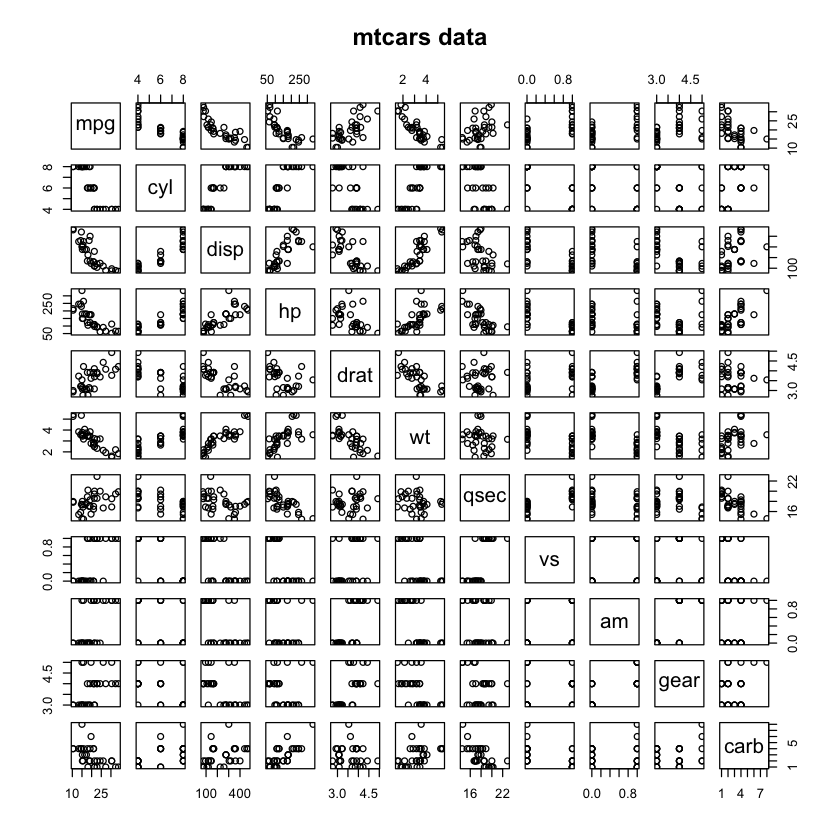

In [6]:
require(graphics)
pairs(mtcars, main = "mtcars data")

After you are done with the `ir` kernel, you can switch back to the SoS kernel using magic

In [7]:
%use sos

SoS will interpolate cell content before it is passed to the subkernel. For example, if you save a dataframe to a file with name in `filename`,

In [8]:
%sandbox
import pandas as pd
import numpy as np
data = pd.DataFrame(np.random.randn(6,4),columns=list('ABCD'))
filename = 'mydata.csv'
data.to_csv(filename, index=False)
data

,A,B,C,D
0,0.879544,-0.080250,1.467453,-1.895600
1,-0.502454,-1.255531,-0.968708,-0.435394
2,-0.483530,0.107089,0.720640,-0.318480
3,1.433339,1.043555,0.378826,-0.293692
4,-0.204646,1.454803,-0.246533,0.068672
5,1.557442,0.290114,1.685035,1.530090


you can pass the filename to kernel `ir` using `${filename}` as follows

In [9]:
%use R
d <- read.csv(${filename!r})
d

d <- read.csv('mydata.csv')
d
## -- End interpolated command --


Warning message in file(file, "rt"):
“cannot open file 'mydata.csv': No such file or directory”

ERROR: Error in file(file, "rt"): cannot open the connection


Although string interpolation allows you to **compose** scripts in other languages, it is not a particularly good way to exchange data between SoS and subkernels. Fortunately, the SoS kernel provides a mechanism to pass variables between SoS and some subkernels using SoS magics.

For example, magic `%get` can get specified SoS variables from the SoS kernel to the subkernel `ir`.

In [ ]:
%get data
data

SoS tries its best to find the best-matching data types between SoS and the subkernel and convert the data in the subkernel's native datatypes (e.g. Python's `DataFrame` to R's `data.frame`), so the variables you get will always be in the subkernel's native data types, not a wrapper of a foreign object (for example objects provided by `rpy2`). 

In [ ]:
class(data)

Unfortunately, although any subkernel can be started, SoS currently only support data exchange between `SoS`, `python3`, and `ir` kernels. SoS provides [an interface to add support for other languages](Extending_SoS.html). Please considering adding SoS support for your favoriate kernel with a pull request.

In [ ]:
%use sos

## SOS Magics

In addition to SoS statements, you can use a few SoS magics in Jupyter notebook. **SoS magics have to be specified at the beginning of a cell** although they can be specified after empty lines and comments, and multiple magics can be used in a single cell.

SoS supports the following jupyter magics:

###  `%use kernel` 

As shown above, the `%use kernel` magic starts or switch to a subkernel named `kernel`. The kernel can be any locally installed Jupyter kenel, or name of a **language** (e.g. `R` for kernel `ir`). A `language` is usually built upon the corresponding subkernel, with added support for data exchange between SoS and the subkernel.

`%use` magic accepts parameters `--in (-i)` and `--out (-o)`, followed by variables that will be transferred to the subkernel after starting (or switching to) the subkernel, and variables that will be transferred back to SoS before magic `%use sos`.

For example,

In [ ]:
n = 5

In [ ]:
%use R -i n -o ran
ran <- rnorm(n)

In [ ]:
%use sos
ran

Data exchange is actually performed by magics `%get` and `%put` so please refer to these magics for details.

### `%with kernel`

  `%with kernel` also starts (or switches to) a subkernel, but kernel specified by `%with kernel` will be reset as soon as the cell is executed. This magic is therefore suitable for a quick errand to another kernel. This magic also accepts options `--in` (or `-i`) and `--out` (or `-o`), so you could use

In [ ]:
%with R -i n -o ran
ran <- rnorm(n)

to get a list of normally distributed numbers using R's `rnorm` function. The current kernel is still `sos`.

In [ ]:
%use

In [ ]:
ran

### `%preview [filename1] [filename2] [expr1] [expr2] ...`

The `%preview` magic preview the content of specified files or values of specified expressions **after** the execution of the current cell. For example, in a subkernel R, you can do

In [ ]:
%with R
%preview a.png
png('a.png')
plot(seq(1,10))
dev.off()

to preview `a.png` generated by this step. Note that SoS automatically previews output files of SoS statements specified by the `output:` directive, but `output:` works only in the SoS kernel and `%preview` works for subkernel.

The magic also accept sos variable and expressions. For example,

In [ ]:
%preview data
import pandas as pd
data = pd.DataFrame({
    'one' : pd.Series([1., 2., 3.], index=['a', 'b', 'c']),
    'two' : pd.Series([1., 2., 3., 4.], index=['a', 'b', 'c', 'd'])})

would display the content of the pandas `DataFrame`. You can specify any Python (sos) expression for this magic but, similar to command line arguments, you will need to quote the expression if it contains spaces. For example,

In [ ]:
%preview data['one']
data = pd.DataFrame({
    'one' : pd.Series([1., 2., 3.], index=['a', 'b', 'c']),
    'two' : pd.Series([1., 2., 3., 4.], index=['a', 'b', 'c', 'd'])})

It is worth mentioning that you can inspect content of variables in Jupyter using `Shift-Tab` when you move your cursor in or after the variable. The advantage (and disadvantage) of the `%preview` magic compared to that method is that its output will be saved in the notebook. 

### `%put`

Magics `%put` are used to return results from subkernel to SoS kernel when the current kernel is a subkernel started by magic `%use`. Only the `ir` and `python` kernels are supported now. Whereas there is virtually no limit on exchangeable datatypes between `SoS` and `python` kernels, there are no perfect map between Python (SoS) and `R` datatypes so SoS tries to find the best match between data types. More specifically,

  
  | R  |  length (n) |   Python |
  | --- | --- |---|
  | `NULL` | |    `None` |
  | `logical` |  `1` |  `oolean` |
  | `integer` |  `1` |  `integer` |
  | `numeric` |  `1` |  `double` |
  | `character` |  `1` |  `string` |
  | `logical` |  `n > 1` |  `list` |
  | `integer` |  `n > 1` |  `list` |
  | `numeric` |  `n > 1` |  `list` |
  | `character` |  `n > 1` |  `list` |
  | `list` without names |  `n > 0` | `list` |
  | `list` with names |  `n > 0` |  `dict` |
  | `matrix` |  `n > 0` |  `numpy.array` |
  | `data.frame` |  `n > 0` |  `DataFrame` |

For example

In [ ]:
%use R
a = c(1)
b = c(1, 2, 3)
c = list(1, 2, 3)
d = list(1, 2, "3")
e = matrix(c(1,2,3,4), ncol=2)

In [ ]:
%put a b c d e
%preview a b c d e

As you can see, although `a` is technically an array with length 1 in `R`, it is convertered to an integer in SoS. Variables `b` and `c` are converted to the same type (`list`) although they are of different types in `R`. Variable `e` are converted from `R` matrix to `numpy` array. 

Sometimes a valid variale name in a subkernel is not a valid name in SoS/Python. SoS would automatically convert such names with a warning message. For example,

In [ ]:
.a.b = 5

In [ ]:
%put .a.b
%preview _a_b

### `%get` (`ir` and `python` kernels only)

Magics `%get` retrieve variables from the SoS to the current subkernel started by magic `%use`. Only the `ir` and `python` kernels are currently supported. SoS tries to use the best matching data type for the conversion. More specifically,

  
  | Python  |  condition |   R |
  | --- | --- |---|
  | `None` | |    `NULL` |
  | `boolean` |   | `logical` |
  | `integer` |  |  `integer` |
  | `float` |  |  `numeric` |
  | `str` |  | `character` |
  | Sequence (`list`, `tuple`, ...) |  homogenous type |  `c()` |
  | Sequence (`list`, `tuple`, ...) |  multiple types |  `list` |
  | `set` |  |  `list` |
  | `dict` |  |  `list` with names |
  | `numpy.ndarray` |  | `c()` array |
  | `numpy.matrix` |  | `matrix` |
  | `pandas.DataFrame` |  |  R `data.frame` |

  Python objects in other datatypes are transferred as string `"Unsupported datatype"`.

For example,

In [ ]:
%use sos
a = [1, 2, 3]
b = [1, 2, "3"]
c = True

In [ ]:
%use R
%get a b c
a

In [ ]:
b

In [ ]:
c

The `%preview` magic cannot be used to preview variables in the subkernel so we have to list them one by one. As you can see, a Python list can be converted to `R` array or list depending on its content. 

Similar to the `%put` magic, SoS automatically translate variables with invalid Python names. For example

In [ ]:
%use sos
_var = 'Hi, Bob'

In [ ]:
%use R
%get _var
.var

In [ ]:
%use sos

### `%paste [command-options] [workflow-options]`

This magic pastes content of clipboard to the cell and execute the cell. It is similar but sometimes more convenient than pasting the content using system shortcuts such as `Cmd-V` (mac). The additional options allow you to execute the pasted workflow with these options (see magic `%run` for details).

### `%run [command-options] [workflow-options]`

The `%sos` magic allows you to specify SoS options such as `-v` (verbosity), `-j` (max number of jobs), and workflow options as defined by `parameter:` keyword. A complete list of arguments can be shown using the `-h` option.

In [ ]:
%use sos
%run -h

### `%set [command-options] [workflow-options]`

The `%set` magic sets a persistent sos options so you do not have to enter them each time after `%run` or `%paste`. For example, if you set `%set -v3`, you can execute all cells in the notebook at verbosity level 3 (`DEBUG`).

Note that this magic only accepts keyword arguments (with leading `-` or `--`) so you cannot use it to specify a default workflow to execute.

In [ ]:
%set -v2
[10]
[20]

In [ ]:
%set -v1
[10]
[20]

### `%matplotlib [GUI]`

Similar to ipython's `matplotlib` magic, the `%matplotlib inline` magic allows the display of matplotlib figures inline in Jupyter notebook or qtconsole.

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0, 10)
plt.plot(x, np.sin(x), '--', linewidth=2)
plt.show()

### `%restart kernel`

`%restart` specified kernel without affecting the current working kernel. 

### `%dict [--reset] [--keys] [--all] var1 var2` 

The `%dict` magic lists or rests the content of SoS dict, using syntax

```
%dict [-a|-all] [-k|--keys] [-r|--reset] [var1] [var2] ...
```

where

* `var1`, `var2` etc are name of variables. All variables will be displayed if no variable is specified.
* `-a|-all`: list all dictionary keys, including SoS functions and variables.
* `-k|--keys`: list only keys, not their values
* `-r|--reset`: reset the dictionary to its original content (with only SoS internal values)

For example, you can see all keys in the SoS dictionary using

In [ ]:
%dict --keys

and reset the dictionary with the `--reset` option

In [ ]:
%dict --reset
%dict --keys

### %sandbox

The `%sandbox` magic executes the current cell in the temporary directory so that it would change files in the current directory.

In [ ]:
!ls Auxil*

In [ ]:
%sandbox
!ls Auxil*

### `%cd dir`

Change current working directory to `dir`.

### `!any-shell-command`

If any other command is entered after `!`, sos will treat the rest of the line as a shell command and execute it. Only single-line commands are supported. String interpolation is supported. Note that `!cd` does not change the current working directory because the command is executed in a separate process. Use magic `%cd` for that purpose.

The command line would accept string interpolation so you can for example do

In [ ]:
filename = 'a.txt'
with open(filename, 'w') as out:
  out.write('something')    

In [ ]:
!cat ${filename}

## Code completion and variable inspection

Code completion are very useful for you to work with a SoS environment. For example, you can enter `<tab>` in
```
%<tab>
```
to get a list of available magics, in
```
%get <tab>
```
to get a list of available variables, in
```
%get dat<tab>
```
to get a list of all variables starting with name `dat`, in
```
%cd ~/<tab>
```
to get a list of all files under the home directory.


Variable inspection is an often-forgotten feature that can be really useful when you work with the SoS kernel. Basically, if you land your cursor on any sos variable or keyword, enter `<Shift-Tab>` to get some information about the variable or keyword. It is often more convenient to use than the `%preview` magic especially if you do not want to keep the output in the notebook. 

## Convert between `.ipynb` and `.sos` files

You can save the notebook to a SoS script using `File` -> `Download As` -> `SoS`, or using command

```
$ sos convert myscript.ipynb myscript.sos
```

The conversion process will strip all results (which can be useful if you would like to version control your notebook without results) but keep cell information and SoS magics. However, **SoS files converted from Jupyter notebook cannot be executed by the `sos` command if they contain SoS magics such as `%use R`** because of non-interactive execution of SoS steps and more rigorous structure required for SoS scripts. You will generally need to modify the resulting script in order to execute it in batch mode.

You can convert an existing SoS script to the `.ipynb` format using command
```
$ sos convert myscript.sos myscript.ipynb
```

and open the resulting notebook from the web interface.

The converter uses lines that starts with `%cell` to split a SoS script into cells of Jupyter notebook. If you have a long script and would like to split it into several cells, you can manually insert `%cell` lines to a `.sos` script before conversion (which would be ignored in batch mode), or split the cells in Jupyter by selecting `Edit -> Split Cell`, or using a keyboard shortcut (`Cmd-Shift-"-"` under Mac).
